---

# **Reinforcement Learning Black Jack** #

Kormishenkov Alexander, Ozerova Daria, Michael Kuznetsov


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import deque
from tqdm.notebook import tqdm  # или просто tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
class SumTree:
    def __init__(self, capacity):
        """
        capacity: размер дерева (макс. кол-во транзакций, хранимых в буфере)
        В реализации мы используем массив-дерево, размер будет 2 * capacity - 1.
        """
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # для хранения приоритетов
        self.data = np.zeros(capacity, dtype=object)  # для хранения самих переходов
        self.write = 0  # индекс, куда записывать новые данные (по кругу)

    def _propagate(self, idx, change):
        """
        Пробрасываем изменения вверх по дереву.
        idx: индекс листа, change: на сколько изменился приоритет
        """
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """
        Рекурсивно спускаемся вниз по дереву, чтобы найти индекс,
        где лежит приоритет, соответствующий значению s (сумме).
        """
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """
        Сумма всех приоритетов (корень дерева).
        """
        return self.tree[0]

    def add(self, priority, data):
        """
        Записать новый переход (data) с приоритетом (priority) в дерево.
        """
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, priority):
        """
        Обновляем приоритет leaf-узла и пробрасываем изменение вверх.
        """
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        """
        Возвращаем (idx, priority, data) по сумме s.
        """
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[dataIdx]


In [50]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100_000):
        """
        capacity: размер буфера
        alpha: [0..1] (степень приоритета). 0 => обычный буфер, 1 => полный приоритет.
        beta_start: начальное значение beta
        beta_frames: кол-во шагов, за которое beta "доходит" до 1.
        """
        self.capacity = capacity
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.beta = beta_start
        self.frame = 1

        self.tree = SumTree(capacity)

        # Для обеспечения минимального приоритета
        self.eps = 1e-5  # небольшая константа, чтобы p не было 0
        self.max_priority = 1.0

    def _update_beta(self):
        """
        Постепенно увеличиваем beta от beta_start до 1.0
        """
        self.beta = min(1.0, self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames)
        self.frame += 1

    def push(self, transition):
        """
        transition = (state, action, reward, next_state, done)
        Начальный приоритет p = max_priority (чтобы новому опыту дать шанс обучаться почаще).
        """
        p = self.max_priority
        self.tree.add(p, transition)

    def sample(self, batch_size):
        """
        Возвращаем батч переходов размером batch_size,
        а также importance-sampling weights и индексы в дереве для последующего обновления.
        """
        # Увеличиваем beta
        self._update_beta()

        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            s = random.random() * segment + i * segment
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        # Вероятности выбора
        total_p = self.tree.total()
        probs = np.array(priorities, dtype=np.float32) / total_p

        # importance-sampling weights
        weights = (batch_size * probs) ** (-self.beta)
        weights /= weights.max()  # нормируем на [0..1]

        # Преобразуем batch в numpy‑массивы
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states), 
            np.array(actions), 
            np.array(rewards), 
            np.array(next_states), 
            np.array(dones), 
            idxs, 
            weights
        )

    def update_priorities(self, idxs, td_errors):
        """
        Обновление приоритетов по индексам idxs и TD-ошибкам td_errors.
        """
        for i, idx in enumerate(idxs):
            p = np.abs(td_errors[i]) + self.eps
            p = p ** self.alpha

            if p > self.max_priority:
                self.max_priority = p

            self.tree.update(idx, p)


In [52]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


class DQN_PER_Agent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,
        gamma=0.99,
        batch_size=64,
        capacity=10_000,
        alpha=0.6,
        beta_start=0.4,
        beta_frames=100_000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10_000,
        target_update_freq=1000
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size

        # eps-greedy
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = self.epsilon_start
        self.step_count = 0

        # Сети
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.target_update_freq = target_update_freq

        # Приоритетный буфер
        self.replay_buffer = PrioritizedReplayBuffer(
            capacity=capacity,
            alpha=alpha,
            beta_start=beta_start,
            beta_frames=beta_frames
        )

        self.losses = []  # чтобы сохранять лосс

    def select_action(self, state):
        """
        eps-жадная стратегия
        """
        self.step_count += 1
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.step_count / self.epsilon_decay)
        )

        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_t)
            action = q_values.argmax(dim=1).item()
            return action

    def remember(self, state, action, reward, next_state, done):
        """
        Кладём переход в буфер (пока без TD-ошибки — она будет добавлена в виде max_priority).
        """
        transition = (state, action, reward, next_state, done)
        self.replay_buffer.push(transition)

    def update(self):
        """
        Обучаемся на одном minibatch-е, используя приоритетный буфер.
        """
        if self.replay_buffer.tree.write < self.batch_size:
            # значит, мы ещё не имеем достаточно данных (или не хотим обучаться при малом количестве)
            return

        # Сэмпл
        states, actions, rewards, next_states, dones, idxs, weights = self.replay_buffer.sample(self.batch_size)

        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.FloatTensor(dones).to(device)
        weights_t = torch.FloatTensor(weights).to(device)

        # Q(s,a)
        q_values = self.q_network(states_t)
        q_values = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

        # Q-target
        with torch.no_grad():
            q_next = self.target_network(next_states_t).max(dim=1)[0]
            q_target = rewards_t + self.gamma * q_next * (1 - dones_t)

        # TD-ошибка
        td_errors = q_target - q_values

        # Лосс с учётом весов
        # При использовании PER обычно берут HuberLoss, умножая на weights
        loss = (weights_t * F.smooth_l1_loss(q_values, q_target, reduction='none')).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Обновляем приоритеты в буфере
        td_errors_cpu = td_errors.detach().cpu().numpy()
        self.replay_buffer.update_priorities(idxs, td_errors_cpu)

        # Периодически копируем веса
        if self.step_count % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.losses.append(loss.item())



In [133]:
def train_dqn_per(
    n_episodes=5_000,
    max_steps_per_episode=100,
    print_every=500
):
    agent = DQN_PER_Agent(
        state_dim=2,
        action_dim=2,  # hit или stick
        lr=1e-3,
        gamma=0.99,
        batch_size=64,
        capacity=10_000,
        alpha=0.9,
        beta_start=0.4,
        beta_frames=50_000,  # за сколько шагов beta дорастёт до 1
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10_000,
        target_update_freq=1000
    )

    all_rewards = []

    for episode in range(1, n_episodes + 1):
        env = Jackblack()
        state = np.array([env.state["dealer_score"], env.state["player_score"]], dtype=np.float32)

        total_reward = 0.0
        done = False

        for t in range(max_steps_per_episode):
            if done:
                break
            action_idx = agent.select_action(state)
            env_action = env.actions[action_idx]

            next_state_dict, reward, done = env.step(env_action)
            next_state = np.array([next_state_dict["dealer_score"], next_state_dict["player_score"]], dtype=np.float32)

            total_reward += reward

            # Сохраняем переход
            agent.remember(state, action_idx, reward, next_state, done)

            # Обновляем агента
            agent.update()

            state = next_state

        all_rewards.append(total_reward)

        if episode % print_every == 0:
            avg_reward = np.mean(all_rewards[-print_every:])
            print(f"[Episode {episode}] avg_reward: {avg_reward:.3f}, epsilon: {agent.epsilon:.3f}")

    return agent, all_rewards


[Episode 500] avg_reward: -0.022, epsilon: 0.915
[Episode 1000] avg_reward: 0.014, epsilon: 0.837
[Episode 1500] avg_reward: -0.058, epsilon: 0.763
[Episode 2000] avg_reward: -0.028, epsilon: 0.691
[Episode 2500] avg_reward: -0.112, epsilon: 0.623
[Episode 3000] avg_reward: -0.034, epsilon: 0.556
[Episode 3500] avg_reward: -0.006, epsilon: 0.492
[Episode 4000] avg_reward: 0.042, epsilon: 0.431
[Episode 4500] avg_reward: -0.008, epsilon: 0.371
[Episode 5000] avg_reward: -0.062, epsilon: 0.313
[Episode 5500] avg_reward: 0.004, epsilon: 0.255
[Episode 6000] avg_reward: 0.050, epsilon: 0.200
[Episode 6500] avg_reward: 0.070, epsilon: 0.146
[Episode 7000] avg_reward: -0.002, epsilon: 0.090
[Episode 7500] avg_reward: 0.020, epsilon: 0.031
[Episode 8000] avg_reward: 0.022, epsilon: 0.010
[Episode 8500] avg_reward: -0.010, epsilon: 0.010
[Episode 9000] avg_reward: 0.054, epsilon: 0.010
[Episode 9500] avg_reward: 0.068, epsilon: 0.010
[Episode 10000] avg_reward: 0.016, epsilon: 0.010
[Episode 1

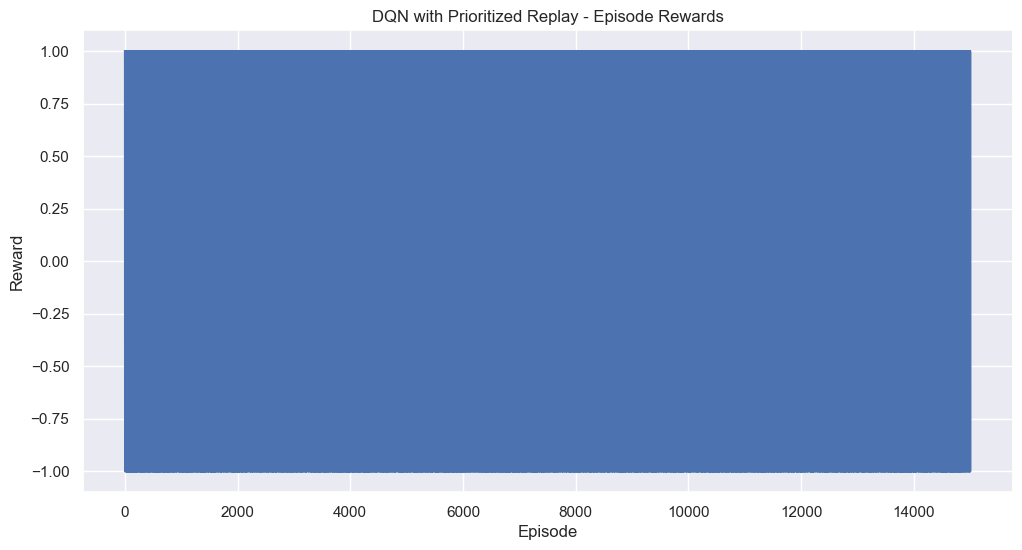

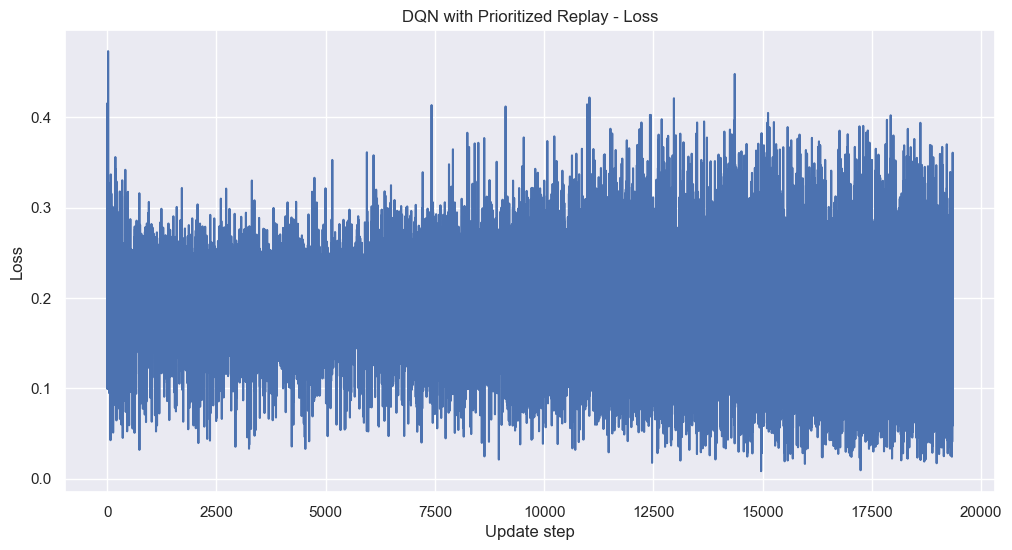

In [134]:
# Запускаем тренировку
agent_per, episode_rewards_per = train_dqn_per(n_episodes=15000, max_steps_per_episode=100, print_every=500)

# Строим график эпизодической награды
plt.figure(figsize=(12,6))
sns.lineplot(x=range(len(episode_rewards_per)), y=episode_rewards_per)
plt.title("DQN with Prioritized Replay - Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Лосс
plt.figure(figsize=(12,6))
sns.lineplot(x=range(len(agent_per.losses)), y=agent_per.losses)
plt.title("DQN with Prioritized Replay - Loss")
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Cumulative rewards example: [1. 2. 3. 4. 3. 2. 1. 0. 1. 2.]


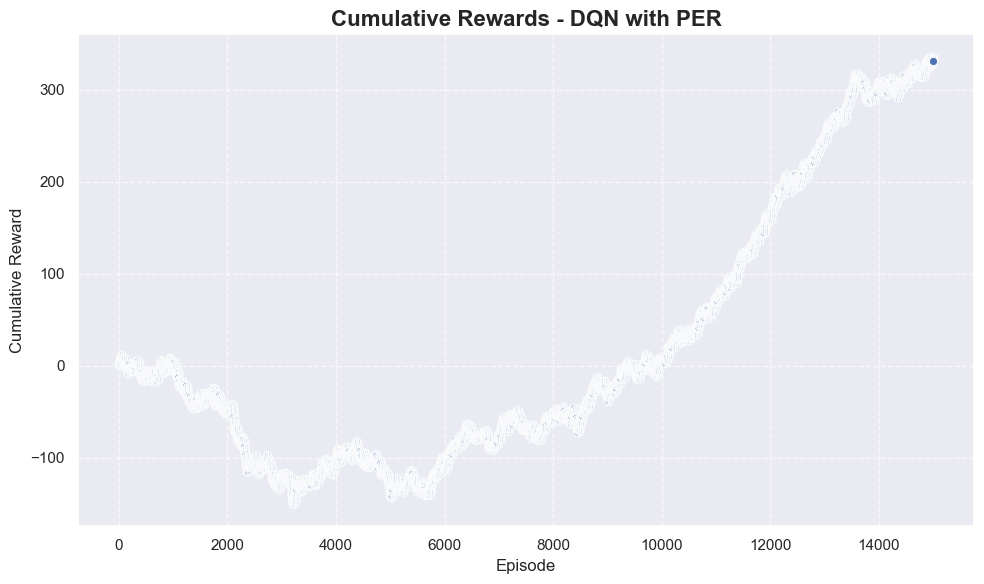

In [135]:
episode_rewards = episode_rewards_per  # из train_dqn_per
cumulative_rewards = calculate_cumulative_rewards(episode_rewards)

if cumulative_rewards is not None:
    print("Cumulative rewards example:", cumulative_rewards[:10])  # первые 10 значений

    # Построим график напрямую из массива
    plot_cumulative_rewards(episode_rewards, 
                            title="Cumulative Rewards - DQN with PER")


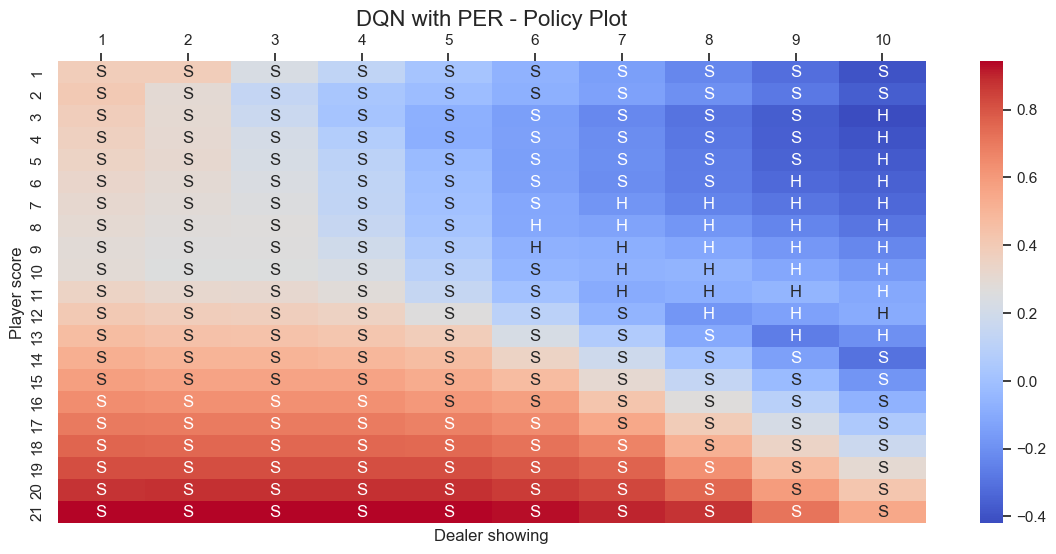

In [58]:
best_actions, best_q = dqn_optimal_policy(agent_per)
plot_dqn_policy(best_actions, best_q, "DQN with PER - Policy Plot")
